# Occupancy Detection in Spinlab with AirQ Data

### A multivariate time series example

In this tutorial, we will apply different frameworks of automated feature engineering to multivariate time series.

Summary:

- Prediction type: __Binary classification__
- Domain: __Energy__
- Prediction target: __Room occupancy__ 
- Source data: __2 tables, 37k rows__
- Population size: __29k__

_Author: Julian Oestreich_

The goal of this work is straight forward. Based on sensordata we want to predict wether is room vacant or not.

This notebook shall also show the effect of additional data on our analysis.

We're using two datasets to analyse the occupancy of rooms with sensordata:
- Dataset collected with a Raspberry Pi in the entrance area of Spinlab:
    - **Variables**:
        * Date, year-month-day hour:minute:second
        * Temperature, in Celsius
        * Relative Humidity, %
        * Light, in Lux
        * Motion_Count, Integer
        * Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status
    - **Size**: 29290 Rows
    - **Resolution**: ~1min
- Dataset created by combining the CSV Exports of the AirQ Webinterface Diagrams:
    - **Variables**:
        * Sound, in db
        * CO2, in ppm
    - **Size**: 8198 Rows
    - **Resolution**: ~4min
    
This notebook is splitted in two parts. The first part is *occupancy detection* on the raspberry pi dataset in combination with the AirQ Webinterface Dataset. The Second part is using our techniques without the additional AirQ data.

Because getML is the only library of the used ones, that comes with a predictor we start by setting a new getML Project because we're using it for every analysis step in this notebook.

In [5]:
import os
import datetime
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('occupancy_airq')

getML API version: 0.13.0

Loading existing project 'occupancy_airq'


# 1. Memory Tracker

Let's use the memory tracker class that was provided by Patrick Urbanke in his [Air Pollution Notebook](https://nbviewer.getml.com/github/getml/getml-demo/blob/master/air_pollution.ipynb) to keep track of our memory consumption.

In [6]:
import threading
import psutil
import time

In [7]:
class MemoryTracker():
    """
    The MemoryTracker measures the system's memory consumption
    once every second. It can be used to get an approximation of 
    the overall memory consumption of certain algorithms.
    """
    
    def __init__(self):
        self._initial_usage = 0
        self._max_usage = 0
        
        self._stop = False
        
        self.lock = threading.Lock()
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
    def __del__(self):
        self.stop()
        
    def _get_memory_usage(self):
        return psutil.virtual_memory().used

    def _measure_memory_usage(self):
        while True:
            time.sleep(1)
            
            self.lock.acquire()
                                    
            if self._stop:
                self.lock.release()
                break
            
            current_usage = self._get_memory_usage()
            
            if current_usage > self._max_usage:
                self._max_usage = current_usage
            
            self.lock.release()

    @property
    def peak_consumption(self):
        """
        The peak system memory consumption, in GB
        """
        self.lock.acquire()
        
        p_con = self._max_usage - self._initial_usage
        
        self.lock.release()
        
        p_con /= 1e9
        
        return p_con
    
    def start(self):
        """
        Starts measuring the memory consumption.
        """
        self.lock.acquire()
        
        self._initial_usage = self._get_memory_usage()
        
        self._max_usage = self._initial_usage
        
        self._stop = False
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
        self.th.start()
        
        self.lock.release()
        
    def stop(self):
        """
        Stops measuring the memory consumption.
        """
        self.lock.acquire()
        self._stop = True
        self.lock.release()

In [8]:
memory_tracker = MemoryTracker()

# 2. Data Preparation and Visualization

In [9]:
airq_data = pd.read_csv('combined.csv', sep=';')
spinlab_data = pd.read_csv('spinlab_19.11.20.csv')

In [10]:
spinlab_data["date"] = pd.to_datetime(spinlab_data["created_time"])
spinlab_data.occupancy.replace(('f', 't'), (0, 1), inplace=True)
spinlab_data.drop('people_count', 1, inplace=True)
spinlab_data.drop('id', 1, inplace=True)
spinlab_data.drop('created_time', 1, inplace=True)
spinlab_data.dropna(inplace=True)
spinlab_data

,temperature,humidity,light,occupancy,date
0,21.299999,49.200001,0.000000,0,2020-10-28 17:17:02.752521+00:00
1,21.299999,49.700001,14.166667,0,2020-10-28 17:18:32.387812+00:00
2,21.299999,49.799999,14.166667,0,2020-10-28 17:19:32.983309+00:00
3,21.299999,49.799999,14.166667,0,2020-10-28 17:20:33.578042+00:00
4,21.299999,49.799999,14.166667,0,2020-10-28 17:21:34.173782+00:00
...,...,...,...,...,...
29285,21.400000,46.500000,1.666667,0,2020-11-18 06:29:43.843737+00:00
29286,21.400000,46.500000,1.666667,0,2020-11-18 06:30:44.438517+00:00
29287,21.299999,46.500000,1.666667,0,2020-11-18 06:31:45.033210+00:00
29288,21.400000,46.599998,1.666667,0,2020-11-18 06:32:45.628052+00:00


In [11]:
airq_data['sound'] = airq_data['sound'].str.replace(',','.').astype(float)
airq_data['co2'] = airq_data['co2'].str.replace(',','.').astype(float)
airq_data["date"] = pd.to_datetime(airq_data["date"])

In [12]:
airq_data

,date,sound,co2
0,2020-10-27 23:04:01,38.6815,466.4755
1,2020-10-27 23:08:02,38.5130,463.3480
2,2020-10-27 23:12:04,38.5720,464.1220
3,2020-10-27 23:16:05,38.4320,465.1120
4,2020-10-27 23:20:08,38.5365,465.8085
...,...,...,...
8193,2020-11-19 22:41:21,38.2840,518.4935
8194,2020-11-19 22:45:22,38.1280,517.8640
8195,2020-11-19 22:49:24,38.2845,514.4445
8196,2020-11-19 22:53:26,38.5625,516.1480


In [13]:
start_date = '2020-11-04'
end_date = '2020-11-07'

airq_mask = (airq_data['date'] > start_date) & (airq_data['date'] <= end_date)
airq_slice = airq_data.loc[airq_mask]

spinlab_mask = (spinlab_data['date'] > start_date) & (spinlab_data['date'] <= end_date)
spinlab_slice = spinlab_data.loc[spinlab_mask]

In [14]:
airq_slice

,date,sound,co2
2512,2020-11-04 00:02:35,38.5480,542.8270
2513,2020-11-04 00:06:36,38.4670,545.0555
2514,2020-11-04 00:10:37,38.4310,543.9495
2515,2020-11-04 00:14:39,38.4880,541.9145
2516,2020-11-04 00:18:39,38.4970,542.1235
...,...,...,...
3575,2020-11-06 23:42:50,42.3425,639.0235
3576,2020-11-06 23:46:51,42.4775,638.2975
3577,2020-11-06 23:50:54,42.4445,638.5220
3578,2020-11-06 23:54:55,42.3950,638.4690


In [15]:
spinlab_slice['temperature']

8942     21.200001
8943     21.200001
8944     21.200001
8945     21.200001
8946     21.200001
           ...    
13213    20.900000
13214    20.900000
13215    20.900000
13216    20.900000
13217    20.900000
Name: temperature, Length: 4276, dtype: float64

In [16]:
max(spinlab_slice['date'].values)

numpy.datetime64('2020-11-06T23:59:03.807736000')

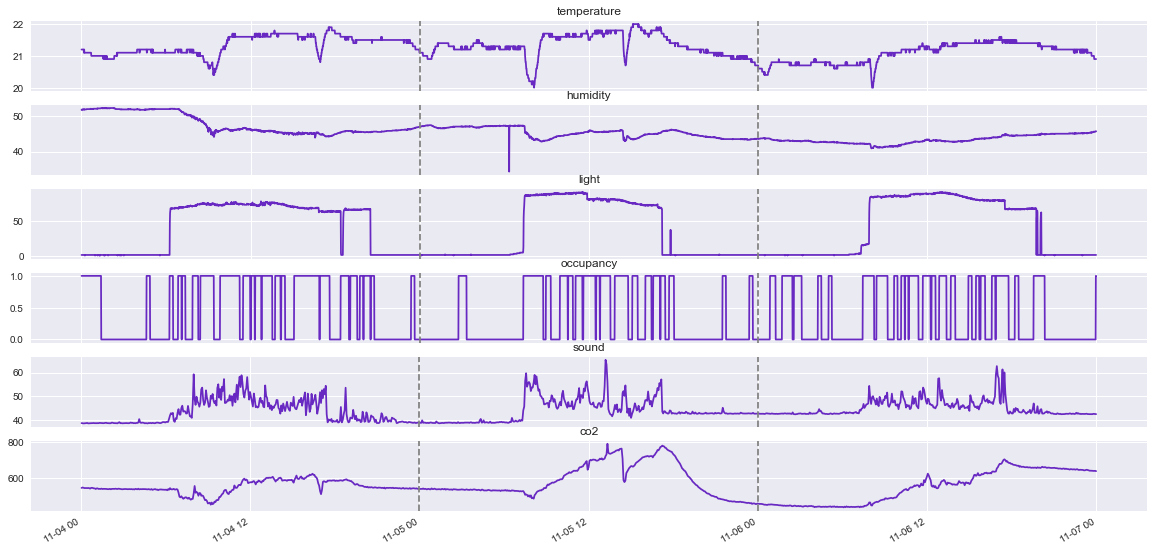

In [17]:
for i, col in enumerate(spinlab_data.columns.values[:-1]):
    plt.subplot(6, 1, i+1) 
    plt.plot(spinlab_slice['date'].values, spinlab_slice[col].values.tolist(), label=col, color='#6829c2')
    plt.axvline('2020-11-05T00:00:00.000000000', color='grey', linestyle='--')
    plt.axvline('2020-11-06T00:00:00.000000000', color='grey', linestyle='--')
    plt.title(col)

for i, col in enumerate(airq_data.columns.values[1:]):
    i = i + 4
    plt.subplot(6, 1, i+1)
    plt.plot(airq_slice['date'].values, airq_slice[col].values.tolist(), label=col, color='#6829c2')
    plt.axvline('2020-11-05T00:00:00.000000000', color='grey', linestyle='--')
    plt.axvline('2020-11-06T00:00:00.000000000', color='grey', linestyle='--')
    plt.title(col)
    
fig, ax = plt.gcf(), plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
fig.set_size_inches(20, 10)
plt.grid(True)
plt.show()

In [18]:
def dt_to_isoformat(x):
    timestring = x.isoformat()
    return timestring.split('+')[0]

In [19]:
spinlab_data['date'] = spinlab_data['date'].apply(dt_to_isoformat)

# 3. With AirQ Data
## 3.1 Automated Feature Engineering with GetML

In [37]:
train = spinlab_data[:int(len(spinlab_data)*0.7)]
test = spinlab_data[int(len(spinlab_data)*0.7):]

In [38]:
air_q = getml.data.DataFrame.from_pandas(airq_data, "air_q")
test = getml.data.DataFrame.from_pandas(test, "test")
train = getml.data.DataFrame.from_pandas(train, "train")

In [39]:
train

Name,temperature,humidity,light,occupancy,date
Role,unused_float,unused_float,unused_float,unused_float,unused_string
0,21.3,49.2,0,0,2020-10-28T17:17:02.752521
1,21.3,49.7,14.1667,0,2020-10-28T17:18:32.387812
2,21.3,49.8,14.1667,0,2020-10-28T17:19:32.983309
3,21.3,49.8,14.1667,0,2020-10-28T17:20:33.578042
4,21.3,49.8,14.1667,0,2020-10-28T17:21:34.173782
,...,...,...,...,...
20498,21.1,43.7,1.66667,0,2020-11-12T02:34:11.292340
20499,21.1,43.7,1.66667,0,2020-11-12T02:35:11.843801
20500,21.1,43.7,1.66667,0,2020-11-12T02:36:12.411774


In [40]:
for df in [train, test]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role(['temperature', 'humidity', 'light'], getml.data.roles.numerical)
    df.set_role("date", getml.data.roles.time_stamp)

In [41]:
train

Name,date,occupancy,temperature,humidity,light
Role,time_stamp,target,numerical,numerical,numerical
Unit,"time stamp, comparison only",,,,
0,2020-10-28T17:17:02.752521Z,0,21.3,49.2,0
1,2020-10-28T17:18:32.387812Z,0,21.3,49.7,14.1667
2,2020-10-28T17:19:32.983309Z,0,21.3,49.8,14.1667
3,2020-10-28T17:20:33.578042Z,0,21.3,49.8,14.1667
4,2020-10-28T17:21:34.173782Z,0,21.3,49.8,14.1667
,...,...,...,...,...
20498,2020-11-12T02:34:11.292340Z,0,21.1,43.7,1.66667
20499,2020-11-12T02:35:11.843801Z,0,21.1,43.7,1.66667


In [42]:
air_q.set_role(['co2', 'sound'], getml.data.roles.numerical)
air_q.set_role("date", getml.data.roles.time_stamp, time_formats=['%Y-%m-%dT%H:%M:%S.%F'])

In [43]:
air_q

Name,date,co2,sound
Role,time_stamp,numerical,numerical
Unit,"time stamp, comparison only",,
0,2020-10-27T23:04:01.000000Z,466.476,38.6815
1,2020-10-27T23:08:02.000000Z,463.348,38.513
2,2020-10-27T23:12:04.000000Z,464.122,38.572
3,2020-10-27T23:16:05.000000Z,465.112,38.432
4,2020-10-27T23:20:08.000000Z,465.808,38.5365
,...,...,...
8193,2020-11-19T22:41:21.000000Z,518.494,38.284
8194,2020-11-19T22:45:22.000000Z,517.864,38.128


In [44]:
population = getml.data.Placeholder('population')

spinlab = getml.data.Placeholder('spinlab')

airq = getml.data.Placeholder('airq')

# 1. The horizon is 0 (we do not predict future data). 
# 2. The memory is 30 mins, so we allow the algorithm to 
#    use information from up to 30 minutes ago. 

population.join(
    spinlab,
    time_stamp='date',
    horizon=getml.data.time.hours(0),
    memory=getml.data.time.minutes(30)
)

population.join(
    airq,
    time_stamp='date',
    horizon=getml.data.time.hours(0),
    memory=getml.data.time.minutes(30)
)

population

placeholder   other placeholder   allow lagged targets   horizon   
population    spinlab             False                  0.0       
population    airq                False                  0.0       



join keys used   memory   other join keys used   other time stamps used   
                 1800.0                          date                     
                 1800.0                          date                     



join keys used   relationship   time stamps used   ...   
                 many-to-many   date               ...   
                 many-to-many   date               ...

In [45]:
multirel = getml.feature_learning.MultirelModel(
    num_features=20,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    #seed=4367,
    #num_threads=6
)

#relboost = getml.feature_learning.RelboostModel(
#    num_features=10,
#    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
#    seed=4367,
#    num_threads=6
#)

predictor = getml.predictors.LogisticRegression()

In [46]:
seasonal = getml.preprocessors.Seasonal()

pipe_airq = getml.pipeline.Pipeline(
    tags=['memory: 30m', 'horizon: 0m', 'multirel', 'relboost'],
    population=population,
    peripheral=[spinlab, airq],
    feature_learners=[multirel],
    predictors=[predictor],
    preprocessors=[seasonal]
)

In [47]:
memory_tracker.start()
start = time.time()
pipe_airq.fit(train, [train, air_q])
memory_tracker.stop()
end=time.time()
print("Elapsed Time: ", (end-start))

print("Memory consumption: ")
print(memory_tracker.peak_consumption)


Checking data model...
OK.

Multirel: Training features...
[========================================] 100%

Multirel: Building features...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:2m:27.679978

Elapsed Time:  149.80350184440613
Memory consumption: 
0.192557056


In [48]:
in_sample = pipe_airq.score(
        population_table=train,
        peripheral_tables=[train, air_q]
)

out_of_sample = pipe_airq.score(
        population_table=test,
        peripheral_tables=[test, air_q]
)



Multirel: Building features...
[========================================] 100%


Multirel: Building features...
[========================================] 100%



In [49]:
in_sample

{'accuracy': [0.8396819977564259],
 'auc': [0.8855753692190834],
 'cross_entropy': [0.3938586789159122]}

In [50]:
out_of_sample

{'accuracy': [0.8185956526687151],
 'auc': [0.8332596721479751],
 'cross_entropy': [0.4428228268127057]}

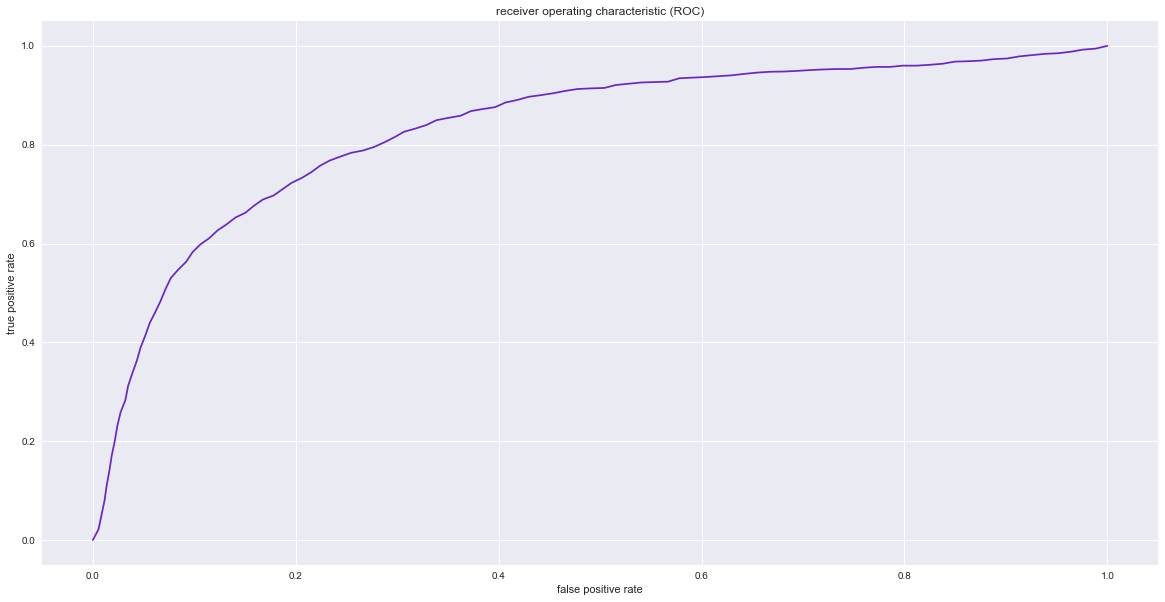

In [53]:
# Refers to the data from the last time
# we called .score(...).
fpr_g, tpr_g = pipe_airq.metrics.roc_curve()

plt.subplots(figsize=(20, 10))
plt.plot(fpr_g, tpr_g, color='#6829c2')
#plt.plot([0.0, 0.0], [1.0, 1.0], ls="-", color='black')
plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

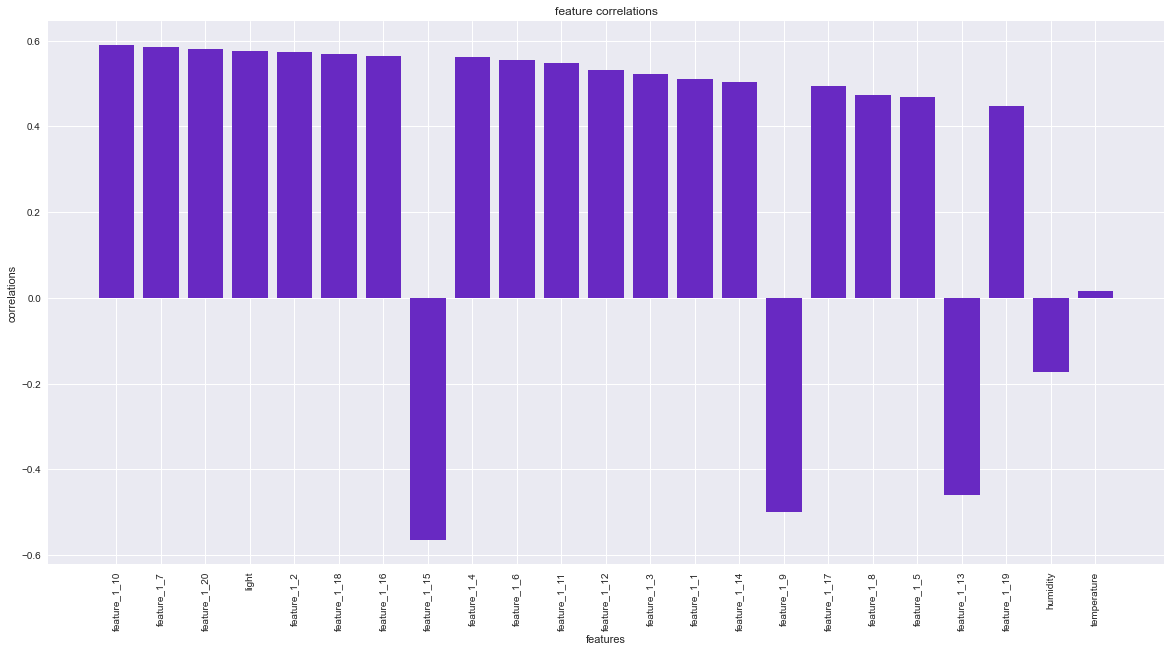

In [54]:
names, correlations = pipe_airq.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')
plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

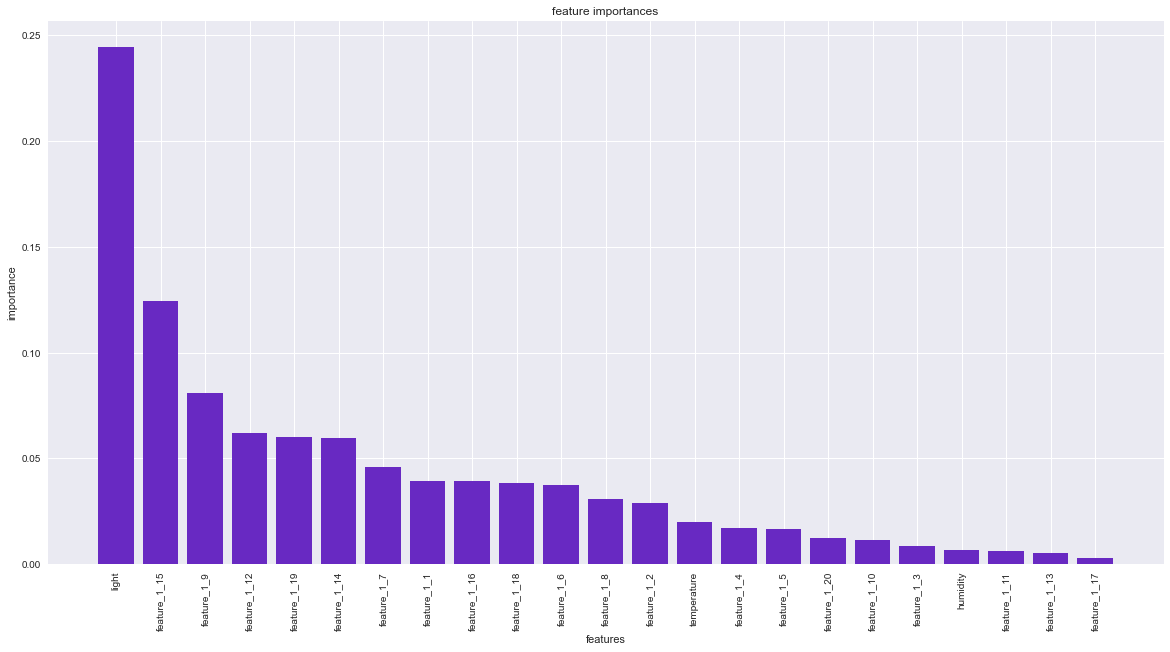

In [626]:
names, importances = pipe_airq.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

In [627]:
pipe_airq.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_15";

CREATE TABLE "FEATURE_1_15" AS
SELECT MIN( ( julianday( t1."date" ) - julianday( t2."date" ) ) * 86400.0 ) AS "feature_1_15",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "airq" t2
ON 1 = 1
WHERE ( julianday( t2."date" ) <= julianday( t1."date" )
AND ( julianday( t2."date", '+30.000000 minutes' ) > julianday( t1."date" ) OR julianday( t2."date", '+30.000000 minutes' ) IS NULL )
) AND (
   ( ( t1."light" > 14.435028 ) AND ( t2."sound" > 45.757500 ) AND ( strftime('%M', t2."date" ) NOT IN ( '17', '18', '05', '07', '10', '12', '13', '15', '26', '31', '49', '57', '58', '34', '35', '36', '40', '41', '42' ) ) AND ( strftime('%M', t2."date" ) NOT IN ( '38' ) ) )
OR ( ( t1."light" > 14.435028 ) AND ( t2."sound" > 45.757500 ) AND ( strftime('%M', t2."date" ) IN ( '17', '18', '05', '07', '10', '12', '13', '15', '26', '31', '49', '57', '58', '34', '35', '36', '40', '41', '42' ) ) AND ( strftime('%M', t1."date" ) IN ( '22', '06', '16', '27', '28', '30', '31', '45', '50', '51', '57', '58', '59', '33', '35', '38', '39', '42' ) ) )
OR ( ( t1."light" > 14.435028 ) AND ( t2."sound" <= 45.757500 OR t2."sound" IS NULL  ) AND ( strftime('%M', t2."date" ) NOT IN ( '17', '19', '23', '00', '03', '05', '08', '09', '10', '13', '14', '15', '26', '27', '28', '29', '30', '31', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '55', '56', '57', '58', '33', '36', '38', '39', '40', '41', '42' ) ) AND ( strftime('%M', t1."date" ) NOT IN ( '18', '00', '02', '03', '05', '07', '08', '09', '26', '27', '45', '47', '49', '52', '55', '59', '35', '36', '37', '38' ) ) )
OR ( ( t1."light" > 14.435028 ) AND ( t2."sound" <= 45.757500 OR t2."sound" IS NULL  ) AND ( strftime('%M', t2."date" ) IN ( '17', '19', '23', '00', '03', '05', '08', '09', '10', '13', '14', '15', '26', '27', '28', '29', '30', '31', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '55', '56', '57', '58', '33', '36', '38', '39', '40', '41', '42' ) ) AND ( strftime('%M', t1."date" ) IN ( '01', '06', '12', '24', '29', '46', '54', '56', '34' ) ) )
OR ( ( t1."light" <= 14.435028 OR t1."light" IS NULL  ) AND ( julianday( t1."date" ) > julianday( t2."date", '+25.100812 minutes' ) ) AND ( julianday( t1."date" ) > julianday( t2."date", '+29.120418 minutes' ) ) AND ( strftime('%H', t2."date" ) IN ( '19' ) ) )
OR ( ( t1."light" <= 14.435028 OR t1."light" IS NULL  ) AND ( julianday( t1."date" ) > julianday( t2."date", '+25.100812 minutes' ) ) AND ( julianday( t1."date" ) <= julianday( t2."date", '+29.120418 minutes' ) ) )
OR ( ( t1."light" <= 14.435028 OR t1."light" IS NULL  ) AND ( julianday( t1."date" ) <= julianday( t2."date", '+25.100812 minutes' ) ) AND ( t2."sound" > 43.791416 ) AND ( strftime('%M', t2."date" ) NOT IN ( '17', '18', '19', '20', '21', '22', '23', '01', '02', '06', '10', '13', '14', '26', '29', '31', '47', '49', '54', '55', '57', '58', '37', '38', '41', '42' ) ) )
OR ( ( t1."light" <= 14.435028 OR t1."light" IS NULL  ) AND ( julianday( t1."date" ) <= julianday( t2."date", '+25.100812 minutes' ) ) AND ( t2."sound" <= 43.791416 OR t2."sound" IS NULL  ) AND ( t1."humidity" > 63.027272 ) )
)
GROUP BY t1.rowid;
```

In [628]:
pipe_airq.features.to_sql()[names[2]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_9";

CREATE TABLE "FEATURE_1_9" AS
SELECT SUM( t2."co2" ) AS "feature_1_9",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "airq" t2
ON 1 = 1
WHERE ( julianday( t2."date" ) <= julianday( t1."date" )
AND ( julianday( t2."date", '+30.000000 minutes' ) > julianday( t1."date" ) OR julianday( t2."date", '+30.000000 minutes' ) IS NULL )
) AND (
   ( ( t2."sound" > 43.508786 OR t2."sound" IS NULL  ) AND ( t1."humidity" > 68.119046 ) AND ( strftime('%M', t1."date" ) NOT IN ( '11' ) ) )
OR ( ( t2."sound" > 43.508786 OR t2."sound" IS NULL  ) AND ( t1."humidity" <= 68.119046 OR t1."humidity" IS NULL  ) AND ( strftime('%M', t2."date" ) NOT IN ( '11' ) ) AND ( strftime('%M', t2."date" ) IN ( '18', '07', '15', '26', '41' ) ) )
OR ( ( t2."sound" > 43.508786 OR t2."sound" IS NULL  ) AND ( t1."humidity" <= 68.119046 OR t1."humidity" IS NULL  ) AND ( strftime('%M', t2."date" ) IN ( '11' ) ) AND ( strftime('%H', t2."date" ) IN ( '10', '12', '13', '14', '15' ) ) )
OR ( ( t2."sound" <= 43.508786 ) AND ( t1."light" > 16.130363 OR t1."light" IS NULL  ) AND ( strftime('%M', t2."date" ) NOT IN ( '23', '01', '15', '26', '27', '28', '29', '30', '32', '44', '45', '46', '48', '49', '51', '52', '53', '55', '56', '57', '59', '33', '36', '37', '38', '41' ) ) AND ( strftime('%M', t1."date" ) IN ( '00', '02', '04', '07', '09', '10', '13', '29', '45', '54', '58' ) ) )
OR ( ( t2."sound" <= 43.508786 ) AND ( t1."light" > 16.130363 OR t1."light" IS NULL  ) AND ( strftime('%M', t2."date" ) IN ( '23', '01', '15', '26', '27', '28', '29', '30', '32', '44', '45', '46', '48', '49', '51', '52', '53', '55', '56', '57', '59', '33', '36', '37', '38', '41' ) ) AND ( strftime('%M', t1."date" ) NOT IN ( '18', '19', '20', '21', '22', '03', '05', '09', '15', '16', '24', '27', '29', '30', '32', '48', '49', '53', '55', '59', '34', '36', '40', '41' ) ) )
OR ( ( t2."sound" <= 43.508786 ) AND ( t1."light" <= 16.130363 ) AND ( t2."sound" > 38.483191 ) AND ( strftime('%M', t2."date" ) IN ( '17', '18', '19', '20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '24', '25', '26', '27', '28', '29', '30', '31', '32', '43', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '33', '34', '35', '36', '37', '38', '39', '41', '42' ) ) )
OR ( ( t2."sound" <= 43.508786 ) AND ( t1."light" <= 16.130363 ) AND ( t2."sound" <= 38.483191 OR t2."sound" IS NULL  ) AND ( strftime('%H', t2."date" ) NOT IN ( '21', '22', '23', '00', '03', '04' ) ) )
)
GROUP BY t1.rowid;
```

In [629]:
pipe_airq.columns.to_pandas()

,population/peripheral,table,name,importance,target
0,[PERIPHERAL],airq,co2,0.009378,occupancy
1,[PERIPHERAL],airq,date,0.068686,occupancy
2,[PERIPHERAL],airq,sound,0.408319,occupancy
3,[PERIPHERAL],spinlab,date,0.008657,occupancy
4,[PERIPHERAL],spinlab,humidity,0.000000,occupancy
5,[PERIPHERAL],spinlab,light,0.002312,occupancy
6,[PERIPHERAL],spinlab,temperature,0.002178,occupancy
7,[POPULATION],population,date,0.083072,occupancy
8,[POPULATION],population,humidity,0.009938,occupancy
9,[POPULATION],population,light,0.385570,occupancy


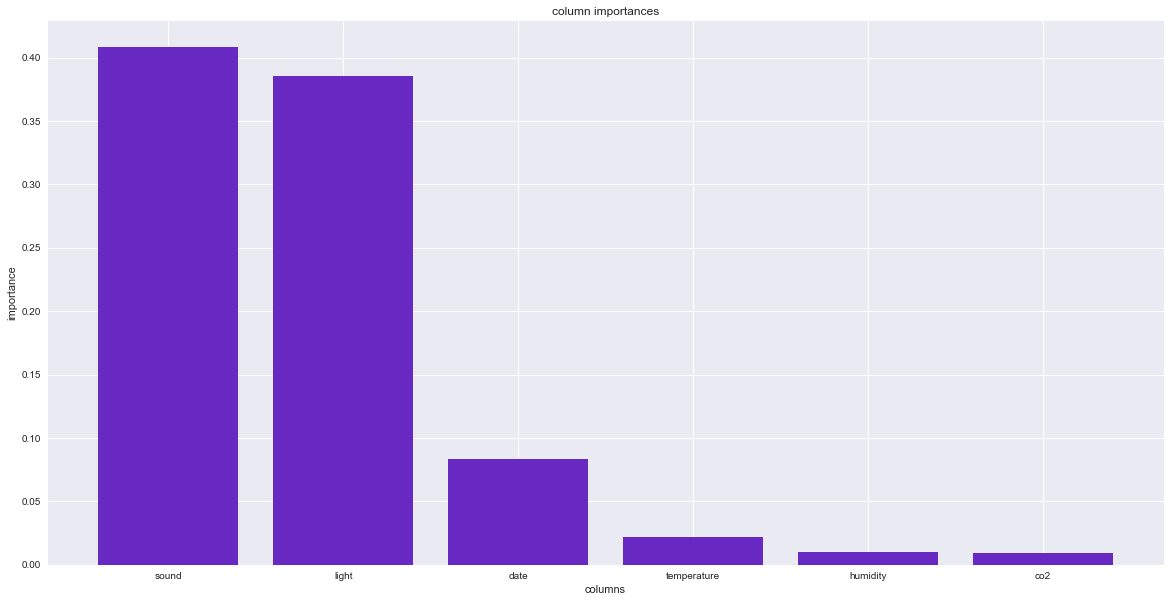

In [55]:
names, importances = pipe_airq.columns.importances()

names = [name.split('.')[1] for name in names]

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importance")
plt.xticks(rotation='horizontal')

plt.show()

## 3.2 Automated Feature Engineering with Featuretools

### 3.2.1 Set Index Column

In [56]:
spinlab_data = spinlab_data.reset_index()
spinlab_data

,index,temperature,humidity,light,occupancy,date
0,0,21.299999,49.200001,0.000000,0,2020-10-28T17:17:02.752521
1,1,21.299999,49.700001,14.166667,0,2020-10-28T17:18:32.387812
2,2,21.299999,49.799999,14.166667,0,2020-10-28T17:19:32.983309
3,3,21.299999,49.799999,14.166667,0,2020-10-28T17:20:33.578042
4,4,21.299999,49.799999,14.166667,0,2020-10-28T17:21:34.173782
...,...,...,...,...,...,...
29285,29285,21.400000,46.500000,1.666667,0,2020-11-18T06:29:43.843737
29286,29286,21.400000,46.500000,1.666667,0,2020-11-18T06:30:44.438517
29287,29287,21.299999,46.500000,1.666667,0,2020-11-18T06:31:45.033210
29288,29288,21.400000,46.599998,1.666667,0,2020-11-18T06:32:45.628052


In [57]:
train = spinlab_data[:int(len(spinlab_data)*0.7)]
test = spinlab_data[int(len(spinlab_data)*0.7):]

In [58]:
airq_data

,date,sound,co2
0,2020-10-27 23:04:01,38.6815,466.4755
1,2020-10-27 23:08:02,38.5130,463.3480
2,2020-10-27 23:12:04,38.5720,464.1220
3,2020-10-27 23:16:05,38.4320,465.1120
4,2020-10-27 23:20:08,38.5365,465.8085
...,...,...,...
8193,2020-11-19 22:41:21,38.2840,518.4935
8194,2020-11-19 22:45:22,38.1280,517.8640
8195,2020-11-19 22:49:24,38.2845,514.4445
8196,2020-11-19 22:53:26,38.5625,516.1480


### 3.2.2. Calculate peripheral tables

In [59]:
import time

In [60]:
peripheral_a = pd.DataFrame()

start = time.time()
for index, row in spinlab_data.iterrows():
    t = pd.to_datetime(row['date'])
    until = t - pd.Timedelta(minutes=30)
    to_add = spinlab_data[(pd.to_datetime(spinlab_data['date']) >= until) & (pd.to_datetime(spinlab_data['date']) <= t)]
    to_add['join_key'] = int(row['index'])
    peripheral_a = peripheral_a.append(to_add)
end = time.time()
print("elapsed time: ", end - start)
    
peripheral_a

<ipython-input-60-70d944274c96>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['join_key'] = int(row['index'])


elapsed time:  1165.5141780376434


,index,temperature,humidity,light,occupancy,date,join_key
0,0,21.299999,49.200001,0.000000,0,2020-10-28T17:17:02.752521,0
0,0,21.299999,49.200001,0.000000,0,2020-10-28T17:17:02.752521,1
1,1,21.299999,49.700001,14.166667,0,2020-10-28T17:18:32.387812,1
0,0,21.299999,49.200001,0.000000,0,2020-10-28T17:17:02.752521,2
1,1,21.299999,49.700001,14.166667,0,2020-10-28T17:18:32.387812,2
...,...,...,...,...,...,...,...
29285,29285,21.400000,46.500000,1.666667,0,2020-11-18T06:29:43.843737,29289
29286,29286,21.400000,46.500000,1.666667,0,2020-11-18T06:30:44.438517,29289
29287,29287,21.299999,46.500000,1.666667,0,2020-11-18T06:31:45.033210,29289
29288,29288,21.400000,46.599998,1.666667,0,2020-11-18T06:32:45.628052,29289


In [61]:
peripheral_b = pd.DataFrame()

start = time.time()
memory_tracker.start()
for index, row in spinlab_data.iterrows():
    t = pd.to_datetime(row['date'])
    until = t - pd.Timedelta(minutes=30)
    to_add = airq_data[(pd.to_datetime(airq_data['date']) >= until) & (pd.to_datetime(airq_data['date']) <= t)]
    to_add['join_key'] = int(row['index'])
    peripheral_b = peripheral_b.append(to_add)
memory_tracker.stop()

print("Memory consumption: ")
print(memory_tracker.peak_consumption)
end = time.time()
print("elapsed time: ", end - start)
    
peripheral_b

<ipython-input-61-01e2f1bfc9ff>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['join_key'] = int(row['index'])


Memory consumption: 
0.266489856
elapsed time:  806.41938996315


,date,sound,co2,join_key
264,2020-10-28 16:48:51,43.6485,599.9780,0
265,2020-10-28 16:52:53,42.8395,596.4740,0
266,2020-10-28 16:56:54,44.0240,599.4685,0
267,2020-10-28 17:00:56,45.2125,596.8625,0
268,2020-10-28 17:04:58,45.6950,600.7980,0
...,...,...,...,...
7594,2020-11-18 06:14:11,38.0210,508.5125,29289
7595,2020-11-18 06:18:13,38.0060,507.1580,29289
7596,2020-11-18 06:22:14,38.1405,507.6770,29289
7597,2020-11-18 06:26:16,38.0830,508.6010,29289


In [62]:
peripheral_a = peripheral_a.drop(['index'], axis=1)
peripheral_a = peripheral_a.reset_index()
peripheral_a = peripheral_a.drop(['index'], axis=1)
peripheral_a = peripheral_a.reset_index()
peripheral_a

,index,temperature,humidity,light,occupancy,date,join_key
0,0,21.299999,49.200001,0.000000,0,2020-10-28T17:17:02.752521,0
1,1,21.299999,49.200001,0.000000,0,2020-10-28T17:17:02.752521,1
2,2,21.299999,49.700001,14.166667,0,2020-10-28T17:18:32.387812,1
3,3,21.299999,49.200001,0.000000,0,2020-10-28T17:17:02.752521,2
4,4,21.299999,49.700001,14.166667,0,2020-10-28T17:18:32.387812,2
...,...,...,...,...,...,...,...
878116,878116,21.400000,46.500000,1.666667,0,2020-11-18T06:29:43.843737,29289
878117,878117,21.400000,46.500000,1.666667,0,2020-11-18T06:30:44.438517,29289
878118,878118,21.299999,46.500000,1.666667,0,2020-11-18T06:31:45.033210,29289
878119,878119,21.400000,46.599998,1.666667,0,2020-11-18T06:32:45.628052,29289


In [63]:
peripheral_b = peripheral_b.reset_index()
peripheral_b = peripheral_b.drop(['index'], axis=1)
peripheral_b = peripheral_b.reset_index()
peripheral_b

,index,date,sound,co2,join_key
0,0,2020-10-28 16:48:51,43.6485,599.9780,0
1,1,2020-10-28 16:52:53,42.8395,596.4740,0
2,2,2020-10-28 16:56:54,44.0240,599.4685,0
3,3,2020-10-28 17:00:56,45.2125,596.8625,0
4,4,2020-10-28 17:04:58,45.6950,600.7980,0
...,...,...,...,...,...
217566,217566,2020-11-18 06:14:11,38.0210,508.5125,29289
217567,217567,2020-11-18 06:18:13,38.0060,507.1580,29289
217568,217568,2020-11-18 06:22:14,38.1405,507.6770,29289
217569,217569,2020-11-18 06:26:16,38.0830,508.6010,29289


### 3.2.3 Create EntitiySet

In [64]:
peripheral_a.drop(["occupancy"], axis=1, inplace=True)

In [65]:
import featuretools as ft
es = ft.EntitySet(id="occupancy_spinlab_airq")

In [66]:

es = es.entity_from_dataframe(entity_id="population",
                              dataframe=spinlab_data,
                              time_index="date",
                              index="index")

es = es.entity_from_dataframe(entity_id="peripheral_spinlab",
                             dataframe=peripheral_a,
                             index='index')

es = es.entity_from_dataframe(entity_id="peripheral_airq",
                             dataframe=peripheral_b,
                             index="index")
es

Entityset: occupancy_spinlab_airq
  Entities:
    population [Rows: 29290, Columns: 6]
    peripheral_spinlab [Rows: 878121, Columns: 6]
    peripheral_airq [Rows: 217571, Columns: 5]
  Relationships:
    No relationships

In [67]:
relationships = []

parent = es["population"]["index"]
child = es["peripheral_airq"]["join_key"]
relationship = ft.Relationship(parent, child)
relationships.append(relationship)

parent = es["population"]["index"]
child = es["peripheral_spinlab"]["join_key"]
relationship = ft.Relationship(parent, child)
relationships.append(relationship)

es.add_relationships(relationships)
es

Entityset: occupancy_spinlab_airq
  Entities:
    population [Rows: 29290, Columns: 6]
    peripheral_spinlab [Rows: 878121, Columns: 6]
    peripheral_airq [Rows: 217571, Columns: 5]
  Relationships:
    peripheral_airq.join_key -> population.index
    peripheral_spinlab.join_key -> population.index

In [68]:
memory_tracker.start()
start = time.time()
features, feature_names = ft.dfs(entityset=es, target_entity='population', 
                                 max_depth = 1)
end  = time.time()
print("Elapsed time: ")
print(end - start)
memory_tracker.stop()

print("Memory consumption: ")
print(memory_tracker.peak_consumption)


features

Elapsed time: 
19.471522092819214
Memory consumption: 
0.112287744


,temperature,humidity,light,occupancy,COUNT(peripheral_airq),MAX(peripheral_airq.co2),MAX(peripheral_airq.sound),MEAN(peripheral_airq.co2),MEAN(peripheral_airq.sound),MIN(peripheral_airq.co2),...,STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date),YEAR(date)
index,,,,,,,,,,,,,,,,,,,,,
0,21.299999,49.200001,0.000000,0,8,600.798,45.6950,597.338438,43.887688,590.8455,...,NaN,NaN,NaN,49.200001,0.000000,21.299999,28,10,2,2020
1,21.299999,49.700001,14.166667,0,8,600.798,45.6950,597.338438,43.887688,590.8455,...,0.353553,10.017346,0.000000,98.900002,14.166667,42.599998,28,10,2,2020
2,21.299999,49.799999,14.166667,0,7,600.798,45.6950,596.961357,43.921857,590.8455,...,0.321454,8.179129,0.000000,148.700001,28.333333,63.899998,28,10,2,2020
3,21.299999,49.799999,14.166667,0,7,600.798,45.6950,596.961357,43.921857,590.8455,...,0.287228,7.083333,0.000000,198.500000,42.500000,85.199997,28,10,2,2020
4,21.299999,49.799999,14.166667,0,8,600.798,45.6950,596.326813,43.627750,590.8455,...,0.260767,6.335526,0.000000,248.299999,56.666667,106.499996,28,10,2,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29285,21.400000,46.500000,1.666667,0,7,509.709,38.1560,508.330857,38.094429,507.1580,...,0.050741,0.000000,0.046609,1396.599976,50.000000,641.099985,18,11,2,2020
29286,21.400000,46.500000,1.666667,0,8,509.709,38.2075,508.049750,38.108563,506.0820,...,0.050854,0.000000,0.046609,1396.499977,50.000000,641.099985,18,11,2,2020
29287,21.299999,46.500000,1.666667,0,8,509.709,38.2075,508.049750,38.108563,506.0820,...,0.050741,0.000000,0.047947,1396.399979,50.000000,640.999985,18,11,2,2020


In [69]:
features = ft.selection.remove_low_information_features(features)
features

,temperature,humidity,light,occupancy,COUNT(peripheral_airq),MAX(peripheral_airq.co2),MAX(peripheral_airq.sound),MEAN(peripheral_airq.co2),MEAN(peripheral_airq.sound),MIN(peripheral_airq.co2),...,SKEW(peripheral_spinlab.temperature),STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date)
index,,,,,,,,,,,,,,,,,,,,,
0,21.299999,49.200001,0.000000,0,8,600.798,45.6950,597.338438,43.887688,590.8455,...,NaN,NaN,NaN,NaN,49.200001,0.000000,21.299999,28,10,2
1,21.299999,49.700001,14.166667,0,8,600.798,45.6950,597.338438,43.887688,590.8455,...,NaN,0.353553,10.017346,0.000000,98.900002,14.166667,42.599998,28,10,2
2,21.299999,49.799999,14.166667,0,7,600.798,45.6950,596.961357,43.921857,590.8455,...,0.000000,0.321454,8.179129,0.000000,148.700001,28.333333,63.899998,28,10,2
3,21.299999,49.799999,14.166667,0,7,600.798,45.6950,596.961357,43.921857,590.8455,...,0.000000,0.287228,7.083333,0.000000,198.500000,42.500000,85.199997,28,10,2
4,21.299999,49.799999,14.166667,0,8,600.798,45.6950,596.326813,43.627750,590.8455,...,0.000000,0.260767,6.335526,0.000000,248.299999,56.666667,106.499996,28,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29285,21.400000,46.500000,1.666667,0,7,509.709,38.1560,508.330857,38.094429,507.1580,...,-0.919500,0.050741,0.000000,0.046609,1396.599976,50.000000,641.099985,18,11,2
29286,21.400000,46.500000,1.666667,0,8,509.709,38.2075,508.049750,38.108563,506.0820,...,-0.919500,0.050854,0.000000,0.046609,1396.499977,50.000000,641.099985,18,11,2
29287,21.299999,46.500000,1.666667,0,8,509.709,38.2075,508.049750,38.108563,506.0820,...,-0.744880,0.050741,0.000000,0.047947,1396.399979,50.000000,640.999985,18,11,2


### 3.2.3 Predictive Modelling & Evaluation

In [70]:
for col in features.columns:
    if features[col].nunique() == 1:
        print(col)
        features.drop([col], axis=1, inplace=True)

In [71]:
ft_train = features[:int(len(features)*0.7)]
ft_test = features[int(len(features)*0.7):]

In [72]:
ft_train_ = getml.data.DataFrame.from_pandas(ft_train, "featuretools_train")
ft_test_ = getml.data.DataFrame.from_pandas(ft_test, "featuretools_test")

In [73]:
ft_train

,temperature,humidity,light,occupancy,COUNT(peripheral_airq),MAX(peripheral_airq.co2),MAX(peripheral_airq.sound),MEAN(peripheral_airq.co2),MEAN(peripheral_airq.sound),MIN(peripheral_airq.co2),...,SKEW(peripheral_spinlab.temperature),STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date)
index,,,,,,,,,,,,,,,,,,,,,
0,21.299999,49.200001,0.000000,0,8,600.798,45.695,597.338438,43.887688,590.8455,...,NaN,NaN,NaN,NaN,49.200001,0.000000,21.299999,28,10,2
1,21.299999,49.700001,14.166667,0,8,600.798,45.695,597.338438,43.887688,590.8455,...,NaN,0.353553,10.017346,0.000000,98.900002,14.166667,42.599998,28,10,2
2,21.299999,49.799999,14.166667,0,7,600.798,45.695,596.961357,43.921857,590.8455,...,0.000000,0.321454,8.179129,0.000000,148.700001,28.333333,63.899998,28,10,2
3,21.299999,49.799999,14.166667,0,7,600.798,45.695,596.961357,43.921857,590.8455,...,0.000000,0.287228,7.083333,0.000000,198.500000,42.500000,85.199997,28,10,2
4,21.299999,49.799999,14.166667,0,8,600.798,45.695,596.326813,43.627750,590.8455,...,0.000000,0.260767,6.335526,0.000000,248.299999,56.666667,106.499996,28,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20498,21.100000,43.700001,1.666667,0,7,635.063,42.496,633.055643,42.415143,631.2560,...,5.477226,0.053499,0.000000,0.018257,1308.899979,50.000000,633.100012,12,11,3
20499,21.100000,43.700001,1.666667,0,7,635.063,42.496,633.055643,42.415143,631.2560,...,5.477226,0.054668,0.000000,0.018257,1308.999981,50.000000,633.100012,12,11,3
20500,21.100000,43.700001,1.666667,0,7,635.063,42.496,633.055643,42.415143,631.2560,...,0.000000,0.054668,0.000000,0.000000,1308.999981,50.000000,633.000011,12,11,3


In [74]:
for df in [ft_train_, ft_test_]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [75]:
ft_train_

Name,occupancy,temperature,humidity,light,COUNT(peripheral_airq),MAX(peripheral_airq.co2),MAX(peripheral_airq.sound),MEAN(peripheral_airq.co2),MEAN(peripheral_airq.sound),MIN(peripheral_airq.co2),MIN(peripheral_airq.sound),SKEW(peripheral_airq.co2),SKEW(peripheral_airq.sound),STD(peripheral_airq.co2),STD(peripheral_airq.sound),SUM(peripheral_airq.co2),SUM(peripheral_airq.sound),COUNT(peripheral_spinlab),MAX(peripheral_spinlab.humidity),MAX(peripheral_spinlab.light),MAX(peripheral_spinlab.temperature),MEAN(peripheral_spinlab.humidity),MEAN(peripheral_spinlab.light),MEAN(peripheral_spinlab.temperature),MIN(peripheral_spinlab.humidity),MIN(peripheral_spinlab.light),MIN(peripheral_spinlab.temperature),SKEW(peripheral_spinlab.humidity),SKEW(peripheral_spinlab.light),SKEW(peripheral_spinlab.temperature),STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date)
Role,target,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
0,0,21.3,49.2,0,8,600.798,45.695,597.338,43.8877,590.846,41.98,-1.12309,-0.00359554,3.29281,1.27103,4778.71,351.102,1,49.2,0,21.3,49.2,0,21.3,49.2,0,21.3,nan,nan,nan,nan,nan,nan,49.2,0,21.3,28,10,2
1,0,21.3,49.7,14.1667,8,600.798,45.695,597.338,43.8877,590.846,41.98,-1.12309,-0.00359554,3.29281,1.27103,4778.71,351.102,2,49.7,14.1667,21.3,49.45,7.08333,21.3,49.2,0,21.3,nan,nan,nan,0.353553,10.0173,0,98.9,14.1667,42.6,28,10,2
2,0,21.3,49.8,14.1667,7,600.798,45.695,596.961,43.9219,590.846,41.98,-0.928901,-0.107145,3.36491,1.36889,4178.73,307.453,3,49.8,14.1667,21.3,49.5667,9.44444,21.3,49.2,0,21.3,-1.5454,-1.73205,0,0.321454,8.17913,0,148.7,28.3333,63.9,28,10,2
3,0,21.3,49.8,14.1667,7,600.798,45.695,596.961,43.9219,590.846,41.98,-0.928901,-0.107145,3.36491,1.36889,4178.73,307.453,4,49.8,14.1667,21.3,49.625,10.625,21.3,49.2,0,21.3,-1.84628,-2,0,0.287228,7.08333,0,198.5,42.5,85.2,28,10,2
4,0,21.3,49.8,14.1667,8,600.798,45.695,596.327,43.6278,590.846,41.569,-0.443451,0.0106278,3.59531,1.51597,4770.61,349.022,5,49.8,14.1667,21.3,49.66,11.3333,21.3,49.2,0,21.3,-2.09224,-2.23607,0,0.260767,6.33553,0,248.3,56.6667,106.5,28,10,2
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20498,0,21.1,43.7,1.66667,7,635.063,42.496,633.056,42.4151,631.256,42.3305,0.238411,-0.245373,1.62179,0.0545449,4431.39,296.906,30,43.7,1.66667,21.2,43.63,1.66667,21.1033,43.5,1.66667,21.1,0.173773,0,5.47723,0.0534992,0,0.0182575,1308.9,50,633.1,12,11,3
20499,0,21.1,43.7,1.66667,7,635.063,42.496,633.056,42.4151,631.256,42.3305,0.238411,-0.245373,1.62179,0.0545449,4431.39,296.906,30,43.7,1.66667,21.2,43.6333,1.66667,21.1033,43.5,1.66667,21.1,0.0502935,0,5.47723,0.0546682,0,0.0182575,1309,50,633.1,12,11,3
20500,0,21.1,43.7,1.66667,7,635.063,42.496,633.056,42.4151,631.256,42.3305,0.238411,-0.245373,1.62179,0.0545449,4431.39,296.906,30,43.7,1.66667,21.1,43.6333,1.66667,21.1,43.5,1.66667,21.1,0.0502935,0,0,0.0546682,0,0,1309,50,633,12,11,3


In [81]:
num_features = 20
predictor = getml.predictors.LogisticRegression()
selector = getml.predictors.LogisticRegression()
#seasonal = getml.preprocessors.Seasonal()

pipe_featuretools = getml.pipeline.Pipeline(
    tags=['featuretools'],
    predictors=[predictor],
    feature_selectors=selector,
    share_selected_features=0.7
    #preprocessors=[seasonal]
)

In [82]:
pipe_featuretools.fit(ft_train_)

Checking data model...
OK.

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:0.312597



Pipeline(preprocessors=[], feature_learners=[], 
         feature_selectors=['LogisticRegression'], include_categorical=False, 
         peripheral=[], population='POPULATION', 
         predictors=['LogisticRegression'], tags=['featuretools'], 
         share_selected_features=0.7)

url: http://localhost:1709/getpipeline/St92kf/0/

In [83]:
in_sample = pipe_featuretools.score(ft_train_)

out_of_sample = pipe_featuretools.score(ft_test_)

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)




Accuracy (training): 0.82095
AUC (training): 0.85556

Accuracy (testing): 0.84466
AUC (testing): 0.84807



In [84]:
in_sample

{'accuracy': [0.8209530312637175],
 'auc': [0.8555623019602464],
 'cross_entropy': [0.4341950882851506]}

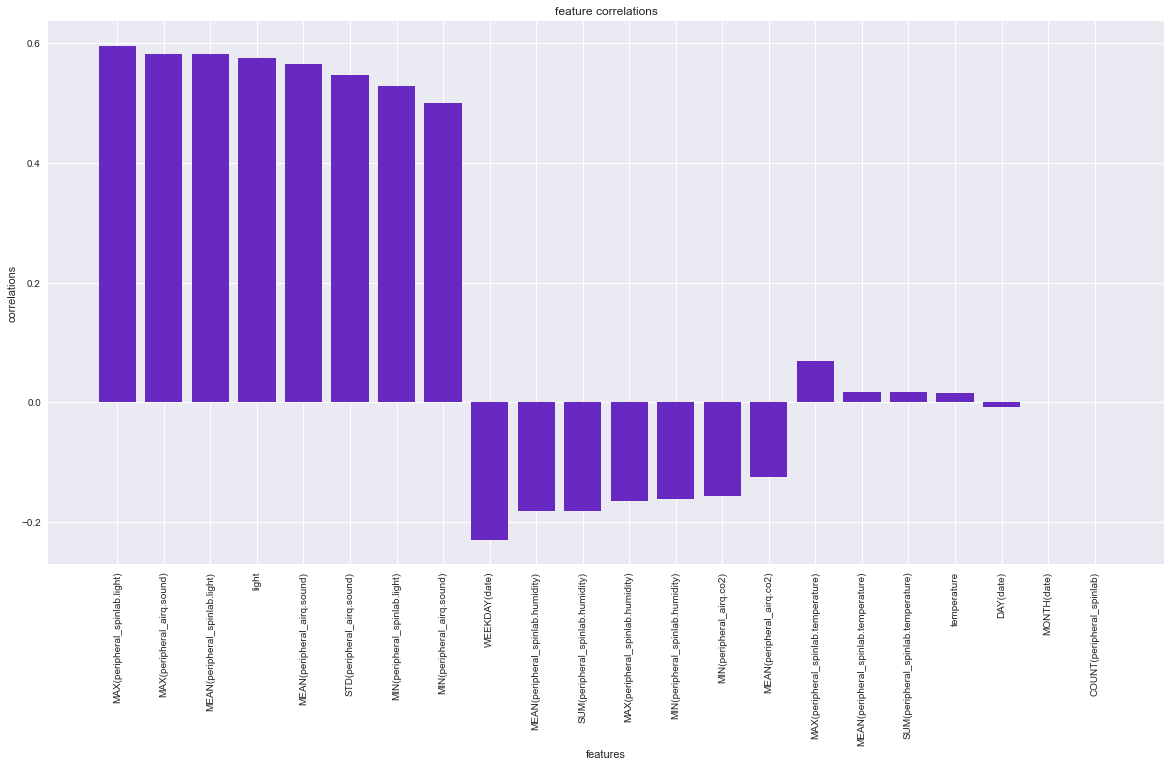

In [85]:
names, correlations = pipe_featuretools.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

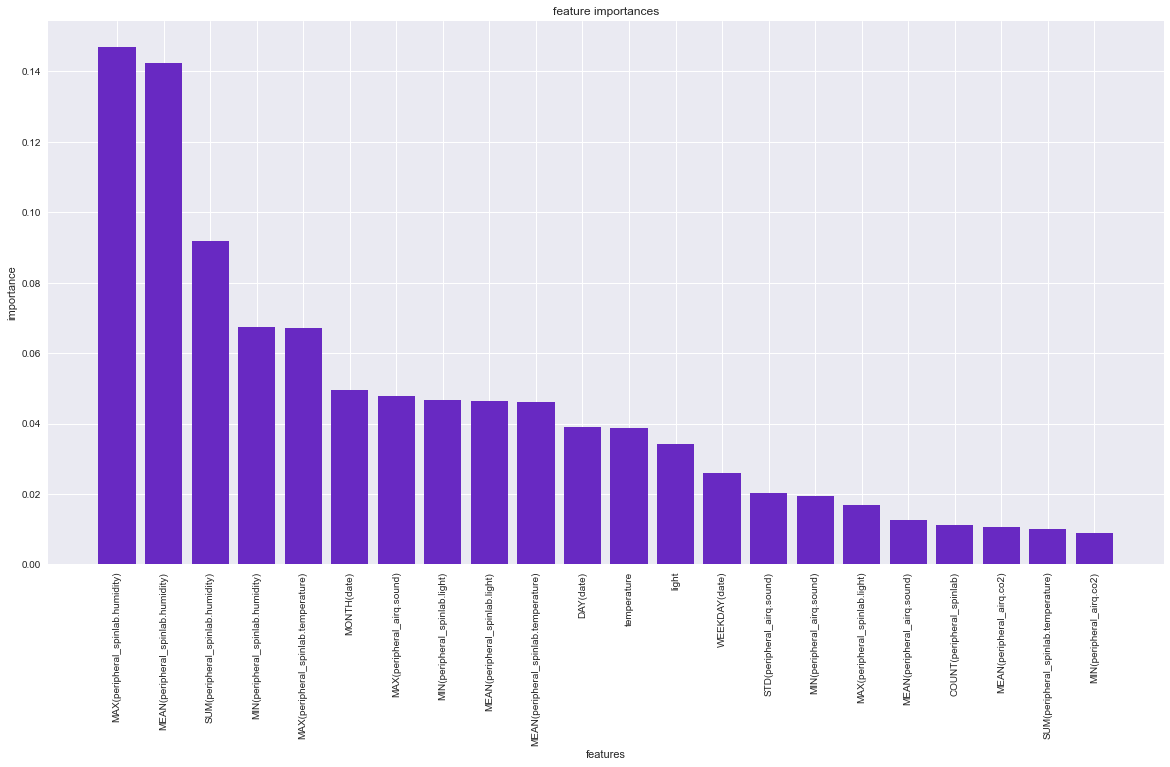

In [87]:
names, importances = pipe_featuretools.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

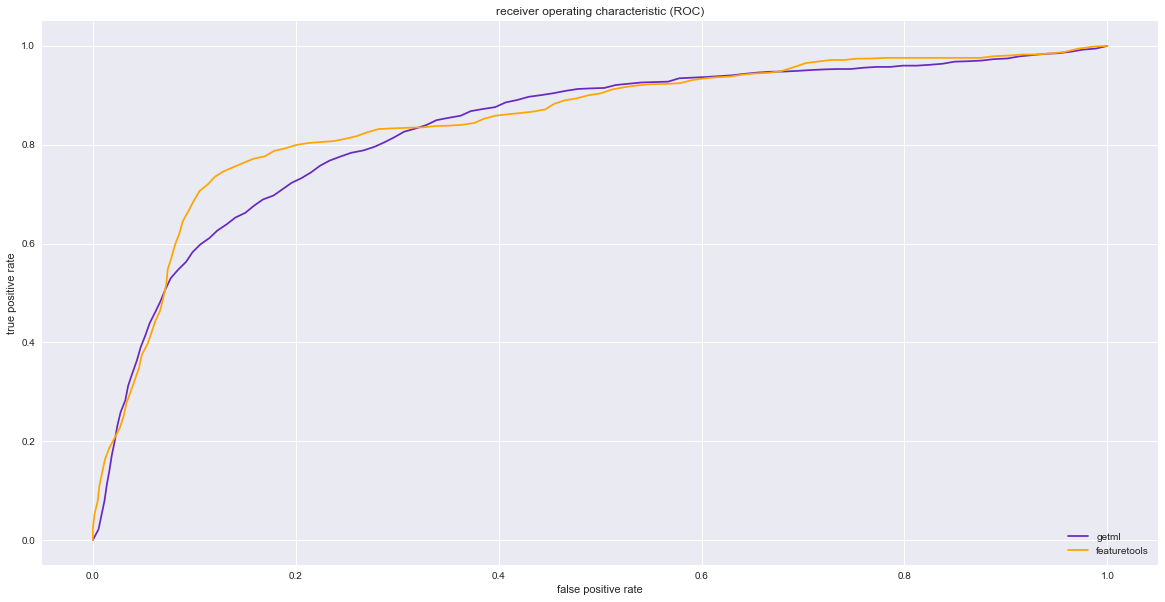

In [88]:
fpr_ft, tpr_ft = pipe_featuretools.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr_g, tpr_g, color='#6829c2', label="getml")
plt.plot(fpr_ft, tpr_ft, color='orange', label="featuretools")
#plt.plot([0.0, 0.0], [1.0, 1.0], ls="-", color='black')
plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.legend(loc="lower right")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

In [89]:
pipe_featuretools.columns.importances()

(array(['[POPULATION] POPULATION.MAX(peripheral_spinlab.humidity)',
        '[POPULATION] POPULATION.MEAN(peripheral_spinlab.humidity)',
        '[POPULATION] POPULATION.SUM(peripheral_spinlab.humidity)',
        '[POPULATION] POPULATION.MIN(peripheral_spinlab.humidity)',
        '[POPULATION] POPULATION.MAX(peripheral_spinlab.temperature)',
        '[POPULATION] POPULATION.MONTH(date)',
        '[POPULATION] POPULATION.MAX(peripheral_airq.sound)',
        '[POPULATION] POPULATION.MIN(peripheral_spinlab.light)',
        '[POPULATION] POPULATION.MEAN(peripheral_spinlab.light)',
        '[POPULATION] POPULATION.MEAN(peripheral_spinlab.temperature)',
        '[POPULATION] POPULATION.DAY(date)',
        '[POPULATION] POPULATION.temperature',
        '[POPULATION] POPULATION.light',
        '[POPULATION] POPULATION.WEEKDAY(date)',
        '[POPULATION] POPULATION.STD(peripheral_airq.sound)',
        '[POPULATION] POPULATION.MIN(peripheral_airq.sound)',
        '[POPULATION] POPULATION.MAX(p

## 4. Without AirQ Data

In [20]:
spinlab_data['join_key'] = 1
train = spinlab_data[:int(len(spinlab_data)*0.7)]
test = spinlab_data[int(len(spinlab_data)*0.7):]

In [21]:
spinlab_data.drop(['index'], axis=1, inplace=True)

KeyError: "['index'] not found in axis"

### 4.1 Automated Feature Engineering with getML

In [22]:
data_full = getml.data.DataFrame.from_pandas(spinlab_data, "data_full")
data_train = getml.data.DataFrame.from_pandas(train, "data_train")
data_test = getml.data.DataFrame.from_pandas(test, "data_test")

In [23]:
for df in [data_full, data_train, data_test]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role(['temperature', 'humidity', 'light'], getml.data.roles.numerical)
    df.set_role("date", getml.data.roles.time_stamp)
    df.set_role('join_key', getml.data.roles.join_key)

In [24]:
data_train

Name,date,join_key,occupancy,temperature,humidity,light
Role,time_stamp,join_key,target,numerical,numerical,numerical
Unit,"time stamp, comparison only",,,,,
0,2020-10-28T17:17:02.752521Z,1,0,21.3,49.2,0
1,2020-10-28T17:18:32.387812Z,1,0,21.3,49.7,14.1667
2,2020-10-28T17:19:32.983309Z,1,0,21.3,49.8,14.1667
3,2020-10-28T17:20:33.578042Z,1,0,21.3,49.8,14.1667
4,2020-10-28T17:21:34.173782Z,1,0,21.3,49.8,14.1667
,...,...,...,...,...,...
20498,2020-11-12T02:34:11.292340Z,1,0,21.1,43.7,1.66667
20499,2020-11-12T02:35:11.843801Z,1,0,21.1,43.7,1.66667


In [99]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

# 1. The horizon is 0 hour (we do not predict the future). 
# 2. The memory is 30 minutes, so we allow the algorithm to 
#    use information from up to 30 minutes ago. 

population.join(
    peripheral,
    time_stamp='date',
    horizon=getml.data.time.hours(0),
    memory=getml.data.time.minutes(30)
)

population

placeholder   other placeholder   allow lagged targets   horizon   
population    peripheral          False                  0.0       



join keys used   memory   other join keys used   other time stamps used   
                 1800.0                          date                     



join keys used   relationship   time stamps used   ...   
                 many-to-many   date               ...

In [100]:
multirel = getml.feature_learning.MultirelModel(
    num_features=20,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
)

#relboost = getml.feature_learning.RelboostModel(
#    num_features=10,
#    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
#)

predictor = getml.predictors.LogisticRegression(reg_lambda=1e-3)

In [106]:
seasonal = getml.preprocessors.Seasonal()

pipe = getml.pipeline.Pipeline(
    tags=['memory: 30m', 'horizon: 0m', 'multirel', 'relboost'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[multirel],
    predictors=[predictor],
    preprocessors=[seasonal]
)

In [107]:
pipe.check(data_train, [data_train])

Checking data model...
OK.


In [108]:
start = time.time()
memory_tracker.start()
pipe.fit(data_train, [data_train])
end= time.time()
memory_tracker.stop()

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

print("elapsed time: ", (end-start))

Checking data model...
OK.

Multirel: Training features...
[========================================] 100%

Multirel: Building features...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:2m:29.111361

Memory consumption: 
0.01374208
elapsed time:  150.83652925491333


In [109]:
in_sample = pipe.score(data_train, [data_train])

out_of_sample = pipe.score(data_test, [data_test])

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)


Multirel: Building features...
[========================================] 100%


Multirel: Building features...
[========================================] 100%


Accuracy (training): 0.83329
AUC (training): 0.87971

Accuracy (testing): 0.84204
AUC (testing): 0.84391



In [110]:
out_of_sample

{'accuracy': [0.8420393763514282],
 'auc': [0.8439101403209184],
 'cross_entropy': [0.4125558659759543]}

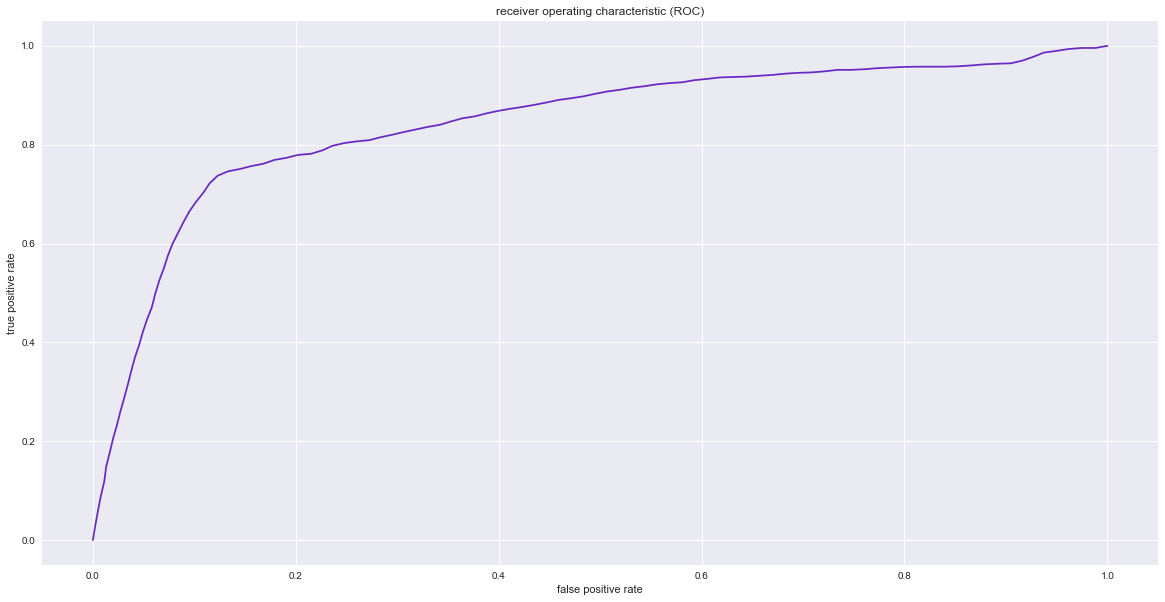

In [111]:
# Refers to the data from the last time
# we called .score(...).
fpr, tpr = pipe.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr, tpr, color='#6829c2')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

In [112]:
predictions = pipe.predict(data_test, [data_test])


Multirel: Building features...
[========================================] 100%



In [113]:
np.unique(predictions)

array([0.04126628, 0.04191949, 0.04237646, ..., 0.96682931, 0.97097249,
       0.97150093])

In [114]:
pipe.deploy

<bound method Pipeline.deploy of Pipeline(preprocessors=['Seasonal'], feature_learners=['MultirelModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['peripheral'], population='population', 
         predictors=['LogisticRegression'], 
         tags=['memory: 30m', 'horizon: 0m', 'multirel', 'relboost'], 
         share_selected_features=0.5)

url: http://localhost:1709/getpipeline/yJtxuJ/0/>

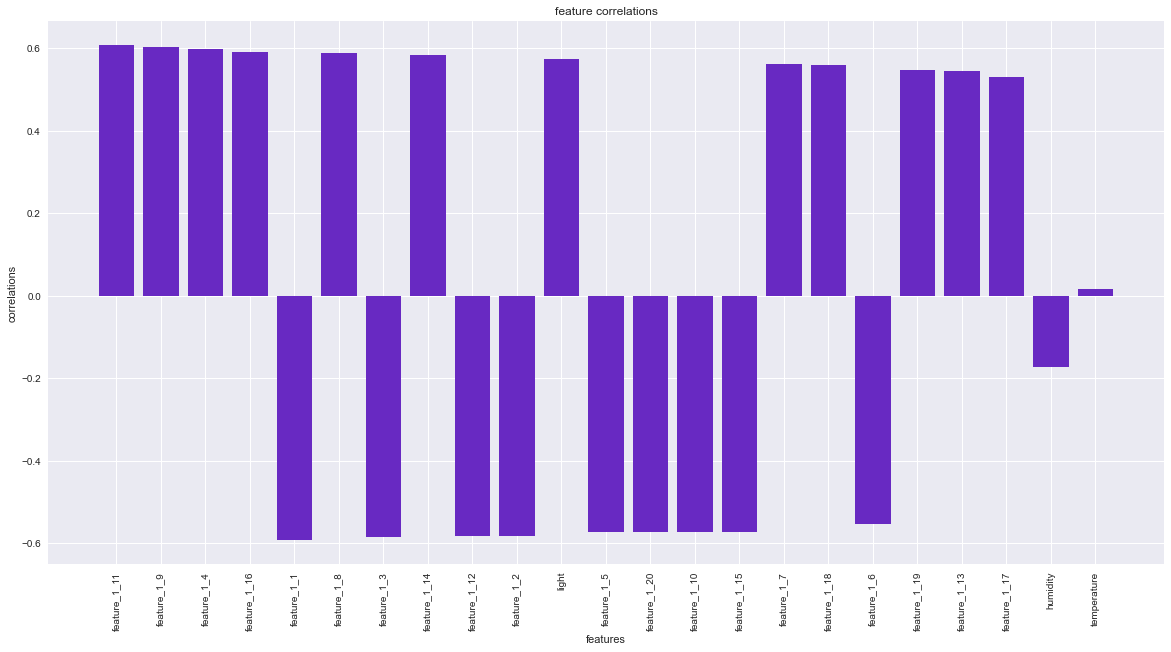

In [115]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')
plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

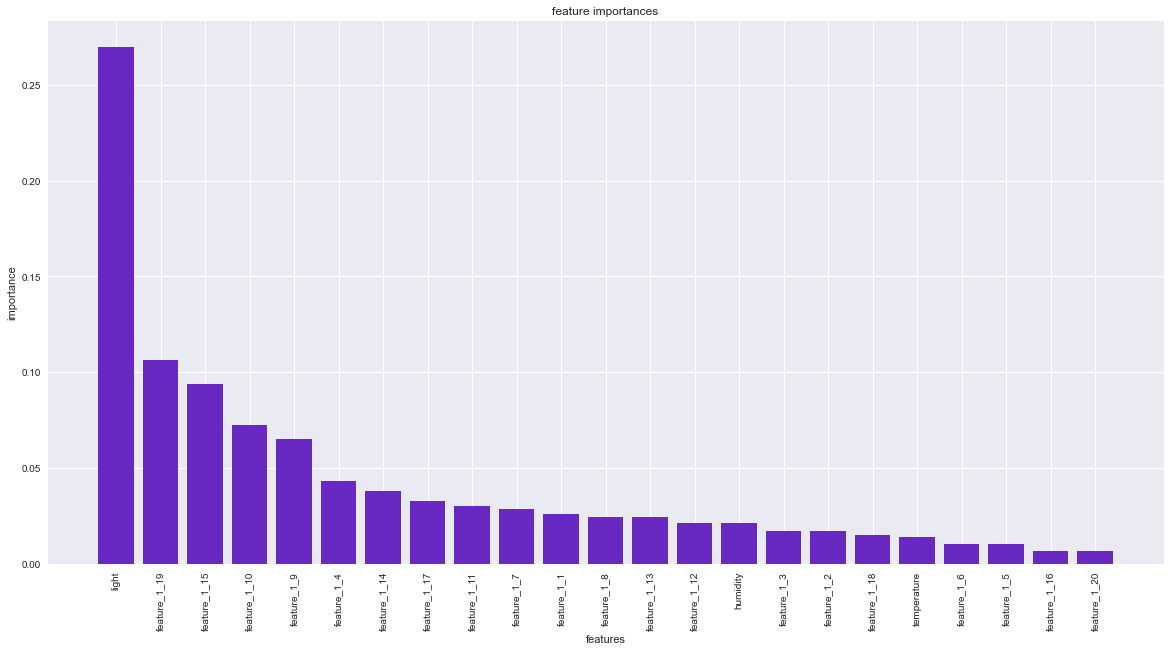

In [116]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

In [117]:
pipe.features.to_sql()[names[2]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_15";

CREATE TABLE "FEATURE_1_15" AS
SELECT AVG( ( julianday( t1."date" ) - julianday( t2."date" ) ) * 86400.0 ) AS "feature_1_15",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON 1 = 1
WHERE ( julianday( t2."date" ) <= julianday( t1."date" )
AND ( julianday( t2."date", '+30.000000 minutes' ) > julianday( t1."date" ) OR julianday( t2."date", '+30.000000 minutes' ) IS NULL )
) AND (
   ( ( t1."light" > 15.819328 OR t1."light" IS NULL  ) AND ( strftime('%H', t2."date" ) NOT IN ( '18', '19', '20', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16' ) ) AND ( strftime('%M', t1."date" ) NOT IN ( '18', '22', '23', '01', '04', '06', '12', '15', '24', '28', '46', '48', '35', '36', '39', '41' ) ) AND ( t2."light" > 36.481481 ) )
OR ( ( t1."light" > 15.819328 OR t1."light" IS NULL  ) AND ( strftime('%H', t2."date" ) NOT IN ( '18', '19', '20', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16' ) ) AND ( strftime('%M', t1."date" ) IN ( '18', '22', '23', '01', '04', '06', '12', '15', '24', '28', '46', '48', '35', '36', '39', '41' ) ) AND ( strftime('%M', t2."date" ) IN ( '54' ) ) )
OR ( ( t1."light" > 15.819328 OR t1."light" IS NULL  ) AND ( strftime('%H', t2."date" ) IN ( '18', '19', '20', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16' ) ) AND ( t1."light" > 88.858974 ) AND ( strftime('%H', t1."date" ) NOT IN ( '10', '11' ) ) )
OR ( ( t1."light" > 15.819328 OR t1."light" IS NULL  ) AND ( strftime('%H', t2."date" ) IN ( '18', '19', '20', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16' ) ) AND ( t1."light" <= 88.858974 OR t1."light" IS NULL  ) AND ( t2."temperature" > 21.982813 ) )
OR ( ( t1."light" <= 15.819328 ) AND ( t2."light" > 13.917090 OR t2."light" IS NULL  ) AND ( strftime('%M', t1."date" ) NOT IN ( '17', '18', '21', '23', '03', '09', '12', '13', '15', '25', '49', '50', '55', '38' ) ) AND ( strftime('%H', t2."date" ) IN ( '20' ) ) )
OR ( ( t1."light" <= 15.819328 ) AND ( t2."light" > 13.917090 OR t2."light" IS NULL  ) AND ( strftime('%M', t1."date" ) IN ( '17', '18', '21', '23', '03', '09', '12', '13', '15', '25', '49', '50', '55', '38' ) ) AND ( strftime('%M', t2."date" ) NOT IN ( '00', '24', '28', '29', '30', '31', '32', '43', '44', '45', '46', '48', '49', '50', '52', '54', '55', '56', '57', '58', '59', '33', '35', '36', '37', '38', '39' ) ) )
OR ( ( t1."light" <= 15.819328 ) AND ( t2."light" <= 13.917090 ) AND ( julianday( t1."date" ) > julianday( t2."date", '+19.254962 minutes' ) ) AND ( t2."humidity" <= 64.055854 ) )
OR ( ( t1."light" <= 15.819328 ) AND ( t2."light" <= 13.917090 ) AND ( julianday( t1."date" ) <= julianday( t2."date", '+19.254962 minutes' ) ) AND ( strftime('%H', t2."date" ) IN ( '23', '00', '02', '03', '07' ) ) )
)
GROUP BY t1.rowid;
```

In [118]:
pipe.columns.to_pandas()

,population/peripheral,table,name,importance,target
0,[PERIPHERAL],peripheral,date,0.048516,occupancy
1,[PERIPHERAL],peripheral,humidity,0.002990,occupancy
2,[PERIPHERAL],peripheral,light,0.436846,occupancy
3,[PERIPHERAL],peripheral,temperature,0.007441,occupancy
4,[POPULATION],population,date,0.052058,occupancy
5,[POPULATION],population,humidity,0.023273,occupancy
6,[POPULATION],population,light,0.413496,occupancy
7,[POPULATION],population,temperature,0.015380,occupancy


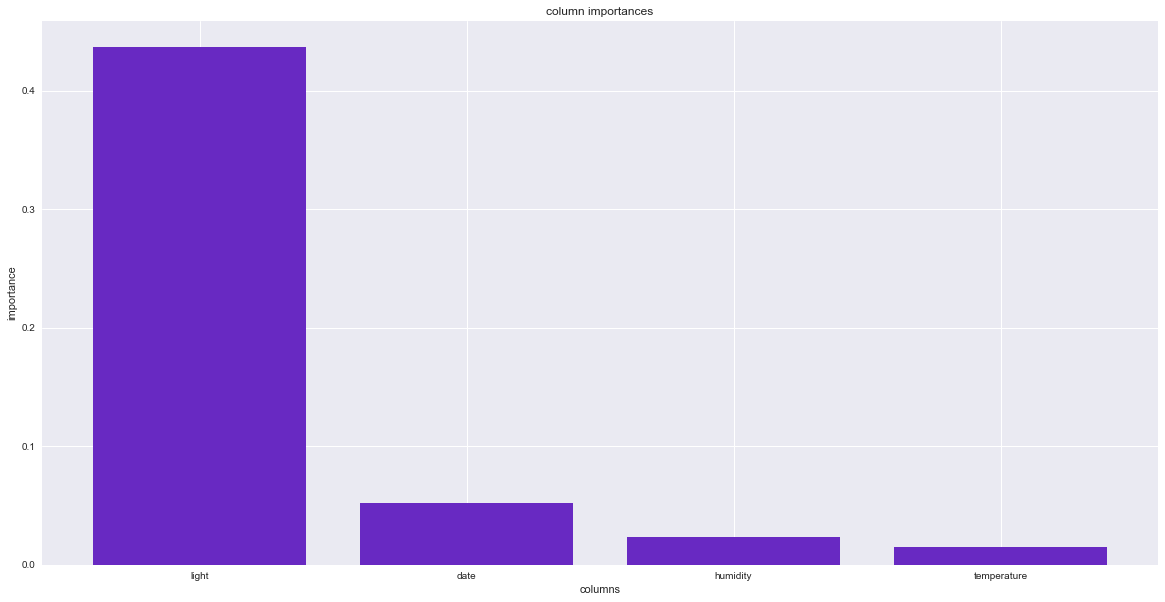

In [119]:
names, importances = pipe.columns.importances()

names = [name.split('.')[1] for name in names]

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importance")
plt.xticks(rotation='horizontal')

plt.show()

## 4.2 Automated Feature Engineering with featuretools

In [120]:
spinlab_data.drop(['join_key'], axis=1, inplace=True)

In [121]:
spinlab_data

,temperature,humidity,light,occupancy,date
0,21.299999,49.200001,0.000000,0,2020-10-28 17:17:02.752521
1,21.299999,49.700001,14.166667,0,2020-10-28 17:18:32.387812
2,21.299999,49.799999,14.166667,0,2020-10-28 17:19:32.983309
3,21.299999,49.799999,14.166667,0,2020-10-28 17:20:33.578042
4,21.299999,49.799999,14.166667,0,2020-10-28 17:21:34.173782
...,...,...,...,...,...
29285,21.400000,46.500000,1.666667,0,2020-11-18 06:29:43.843737
29286,21.400000,46.500000,1.666667,0,2020-11-18 06:30:44.438517
29287,21.299999,46.500000,1.666667,0,2020-11-18 06:31:45.033210
29288,21.400000,46.599998,1.666667,0,2020-11-18 06:32:45.628052


In [122]:
es = ft.EntitySet(id="occupancy_spinlab")

In [123]:

es = es.entity_from_dataframe(entity_id="population",
                              dataframe=spinlab_data,
                              time_index="date",
                              index="index")

es = es.entity_from_dataframe(entity_id="peripheral_spinlab",
                             dataframe=peripheral_a,
                             index='index')

es

/usr/local/lib/python3.8/site-packages/featuretools/entityset/entity.py:610: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


Entityset: occupancy_spinlab
  Entities:
    population [Rows: 29290, Columns: 6]
    peripheral_spinlab [Rows: 878121, Columns: 6]
  Relationships:
    No relationships

In [124]:
relationships = []

parent = es["population"]["index"]
child = es["peripheral_spinlab"]["join_key"]
relationship = ft.Relationship(parent, child)

relationships.append(relationship)

es.add_relationships(relationships)
es

Entityset: occupancy_spinlab
  Entities:
    population [Rows: 29290, Columns: 6]
    peripheral_spinlab [Rows: 878121, Columns: 6]
  Relationships:
    peripheral_spinlab.join_key -> population.index

In [125]:
memory_tracker.start()
start = time.time()
features, feature_names = ft.dfs(entityset=es, target_entity='population', 
                                 max_depth = 1)
end  = time.time()
print("Elapsed time: ")
print(end - start)
memory_tracker.stop()

print("Memory consumption: ")
print(memory_tracker.peak_consumption)


features

Elapsed time: 
10.321538925170898
Memory consumption: 
0.007692288


,temperature,humidity,light,occupancy,COUNT(peripheral_spinlab),MAX(peripheral_spinlab.humidity),MAX(peripheral_spinlab.light),MAX(peripheral_spinlab.temperature),MEAN(peripheral_spinlab.humidity),MEAN(peripheral_spinlab.light),...,STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date),YEAR(date)
index,,,,,,,,,,,,,,,,,,,,,
0,21.299999,49.200001,0.000000,0,1,49.200001,0.000000,21.299999,49.200001,0.000000,...,NaN,NaN,NaN,49.200001,0.000000,21.299999,28,10,2,2020
1,21.299999,49.700001,14.166667,0,2,49.700001,14.166667,21.299999,49.450001,7.083333,...,0.353553,10.017346,0.000000,98.900002,14.166667,42.599998,28,10,2,2020
2,21.299999,49.799999,14.166667,0,3,49.799999,14.166667,21.299999,49.566667,9.444444,...,0.321454,8.179129,0.000000,148.700001,28.333333,63.899998,28,10,2,2020
3,21.299999,49.799999,14.166667,0,4,49.799999,14.166667,21.299999,49.625000,10.625000,...,0.287228,7.083333,0.000000,198.500000,42.500000,85.199997,28,10,2,2020
4,21.299999,49.799999,14.166667,0,5,49.799999,14.166667,21.299999,49.660000,11.333333,...,0.260767,6.335526,0.000000,248.299999,56.666667,106.499996,28,10,2,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29285,21.400000,46.500000,1.666667,0,30,46.599998,1.666667,21.400000,46.553333,1.666667,...,0.050741,0.000000,0.046609,1396.599976,50.000000,641.099985,18,11,2,2020
29286,21.400000,46.500000,1.666667,0,30,46.599998,1.666667,21.400000,46.549999,1.666667,...,0.050854,0.000000,0.046609,1396.499977,50.000000,641.099985,18,11,2,2020
29287,21.299999,46.500000,1.666667,0,30,46.599998,1.666667,21.400000,46.546666,1.666667,...,0.050741,0.000000,0.047947,1396.399979,50.000000,640.999985,18,11,2,2020


In [126]:
features = ft.selection.remove_low_information_features(features)
features = features.dropna()

In [127]:
for col in features.columns:
    if features[col].nunique() == 1:
        print(col)
        features.drop([col], axis=1, inplace=True)

In [128]:
ft_train = features[:int(len(features)*0.7)]
ft_test = features[int(len(features)*0.7):]

In [129]:
ft_train_ = getml.data.DataFrame.from_pandas(ft_train, "featuretools_train")
ft_test_ = getml.data.DataFrame.from_pandas(ft_test, "featuretools_test")

In [130]:
for df in [ft_train_, ft_test_]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [131]:
ft_train_

Name,occupancy,temperature,humidity,light,COUNT(peripheral_spinlab),MAX(peripheral_spinlab.humidity),MAX(peripheral_spinlab.light),MAX(peripheral_spinlab.temperature),MEAN(peripheral_spinlab.humidity),MEAN(peripheral_spinlab.light),MEAN(peripheral_spinlab.temperature),MIN(peripheral_spinlab.humidity),MIN(peripheral_spinlab.light),MIN(peripheral_spinlab.temperature),SKEW(peripheral_spinlab.humidity),SKEW(peripheral_spinlab.light),SKEW(peripheral_spinlab.temperature),STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date)
Role,target,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
0,0,21.3,49.8,14.1667,3,49.8,14.1667,21.3,49.5667,9.44444,21.3,49.2,0,21.3,-1.5454,-1.73205,0,0.321454,8.17913,0,148.7,28.3333,63.9,28,10,2
1,0,21.3,49.8,14.1667,4,49.8,14.1667,21.3,49.625,10.625,21.3,49.2,0,21.3,-1.84628,-2,0,0.287228,7.08333,0,198.5,42.5,85.2,28,10,2
2,0,21.3,49.8,14.1667,5,49.8,14.1667,21.3,49.66,11.3333,21.3,49.2,0,21.3,-2.09224,-2.23607,0,0.260767,6.33553,0,248.3,56.6667,106.5,28,10,2
3,0,21.2,49.7,14.1667,6,49.8,14.1667,21.3,49.6667,11.8056,21.2833,49.2,0,21.2,-2.21674,-2.44949,-2.44949,0.233809,5.78352,0.0408242,298,70.8333,127.7,28,10,2
4,0,21.2,49.7,14.1667,7,49.8,14.1667,21.3,49.6714,12.1429,21.2714,49.2,0,21.2,-2.34731,-2.64575,-1.22963,0.213809,5.3545,0.0487943,347.7,85,148.9,28,10,2
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20496,0,21.1,43.7,1.66667,30,43.7,1.66667,21.2,43.63,1.66667,21.1033,43.5,1.66667,21.1,0.173773,0,5.47723,0.0534992,0,0.0182575,1308.9,50,633.1,12,11,3
20497,0,21.1,43.7,1.66667,30,43.7,1.66667,21.2,43.6333,1.66667,21.1033,43.5,1.66667,21.1,0.0502935,0,5.47723,0.0546682,0,0.0182575,1309,50,633.1,12,11,3
20498,0,21.1,43.7,1.66667,30,43.7,1.66667,21.1,43.6333,1.66667,21.1,43.5,1.66667,21.1,0.0502935,0,0,0.0546682,0,0,1309,50,633,12,11,3


In [132]:
num_features = 24
imputation = getml.preprocessors.Imputation()
predictor = getml.predictors.LogisticRegression()
selector = getml.predictors.LogisticRegression()
seasonal = getml.preprocessors.Seasonal()
share = num_features/(len(features.columns))

pipe_featuretools = getml.pipeline.Pipeline(
    tags=['featuretools'],
    predictors=[predictor],
    feature_selectors=selector,
    share_selected_features=share,
    preprocessors=[imputation]
)

In [133]:
pipe_featuretools.fit(ft_train_)

Checking data model...
OK.

LogisticRegression: Training as feature selector...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:0.683669



Pipeline(preprocessors=['Imputation'], feature_learners=[], 
         feature_selectors=['LogisticRegression'], include_categorical=False, 
         peripheral=[], population='POPULATION', 
         predictors=['LogisticRegression'], tags=['featuretools'], 
         share_selected_features=0.9230769230769231)

url: http://localhost:1709/getpipeline/Omqi5Y/0/

In [134]:
in_sample = pipe_featuretools.score(ft_train_)

out_of_sample = pipe_featuretools.score(ft_test_)

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)




Accuracy (training): 0.81840
AUC (training): 0.85807

Accuracy (testing): 0.83396
AUC (testing): 0.84129



In [139]:
out_of_sample

{'accuracy': [0.833959257994765],
 'auc': [0.8412861176820495],
 'cross_entropy': [0.4107261021671275]}

In [136]:
names, importances = pipe_featuretools.features.importances()

In [137]:
len(names)

23

In [138]:
len(features.columns)

26

In [417]:
ft_train

,temperature,humidity,light,occupancy,COUNT(peripheral_spinlab),MAX(peripheral_spinlab.humidity),MAX(peripheral_spinlab.light),MAX(peripheral_spinlab.temperature),MEAN(peripheral_spinlab.humidity),MEAN(peripheral_spinlab.light),...,SKEW(peripheral_spinlab.temperature),STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date)
index,,,,,,,,,,,,,,,,,,,,,
2,21.299999,49.799999,14.166667,0,3,49.799999,14.166667,21.299999,49.566667,9.444444,...,0.000000,0.321454,8.179129,0.000000,148.700001,28.333333,63.899998,28,10,2
3,21.299999,49.799999,14.166667,0,4,49.799999,14.166667,21.299999,49.625000,10.625000,...,0.000000,0.287228,7.083333,0.000000,198.500000,42.500000,85.199997,28,10,2
4,21.299999,49.799999,14.166667,0,5,49.799999,14.166667,21.299999,49.660000,11.333333,...,0.000000,0.260767,6.335526,0.000000,248.299999,56.666667,106.499996,28,10,2
5,21.200001,49.700001,14.166667,0,6,49.799999,14.166667,21.299999,49.666667,11.805556,...,-2.449490,0.233809,5.783517,0.040824,298.000000,70.833333,127.699997,28,10,2
6,21.200001,49.700001,14.166667,0,7,49.799999,14.166667,21.299999,49.671429,12.142857,...,-1.229634,0.213809,5.354497,0.048794,347.700001,85.000000,148.899998,28,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20498,21.100000,43.700001,1.666667,0,30,43.700001,1.666667,21.200001,43.629999,1.666667,...,5.477226,0.053499,0.000000,0.018257,1308.899979,50.000000,633.100012,12,11,3
20499,21.100000,43.700001,1.666667,0,30,43.700001,1.666667,21.200001,43.633333,1.666667,...,5.477226,0.054668,0.000000,0.018257,1308.999981,50.000000,633.100012,12,11,3
20500,21.100000,43.700001,1.666667,0,30,43.700001,1.666667,21.100000,43.633333,1.666667,...,0.000000,0.054668,0.000000,0.000000,1308.999981,50.000000,633.000011,12,11,3


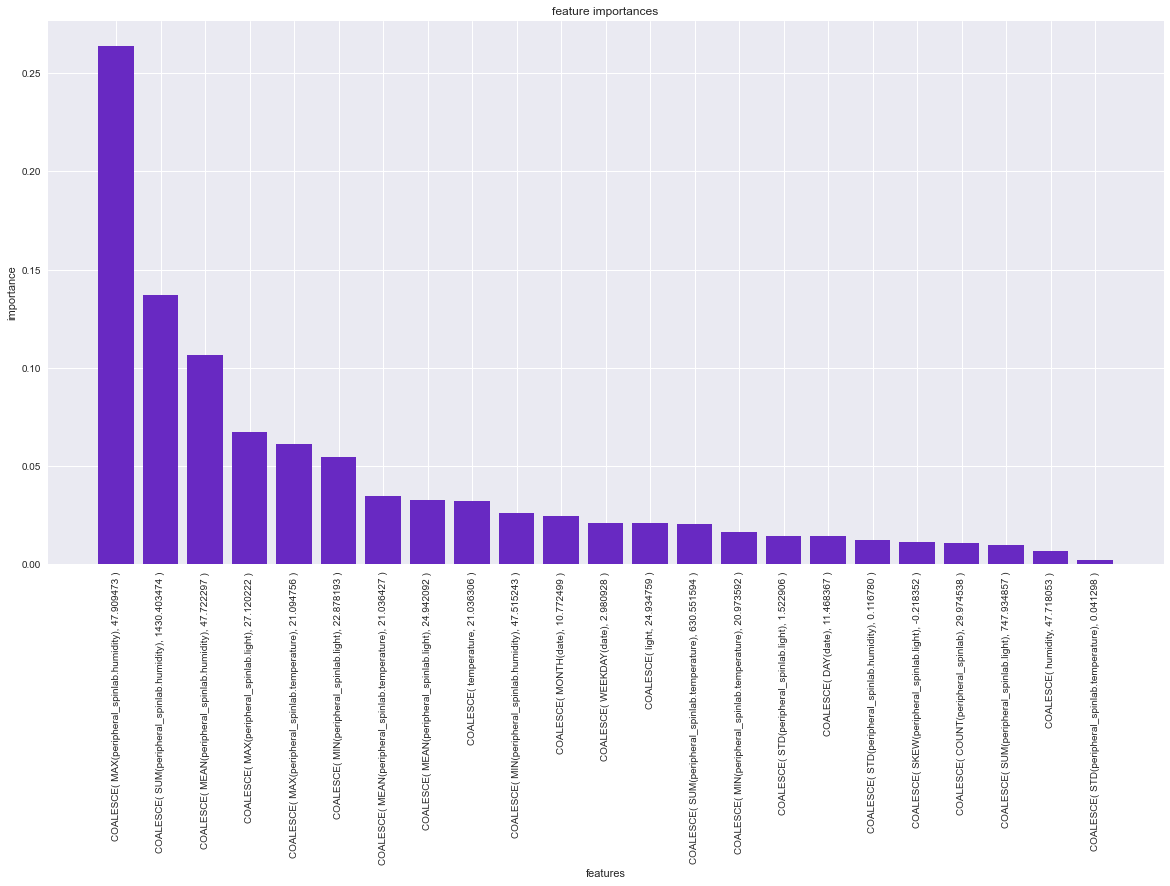

In [140]:
names, importances = pipe_featuretools.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

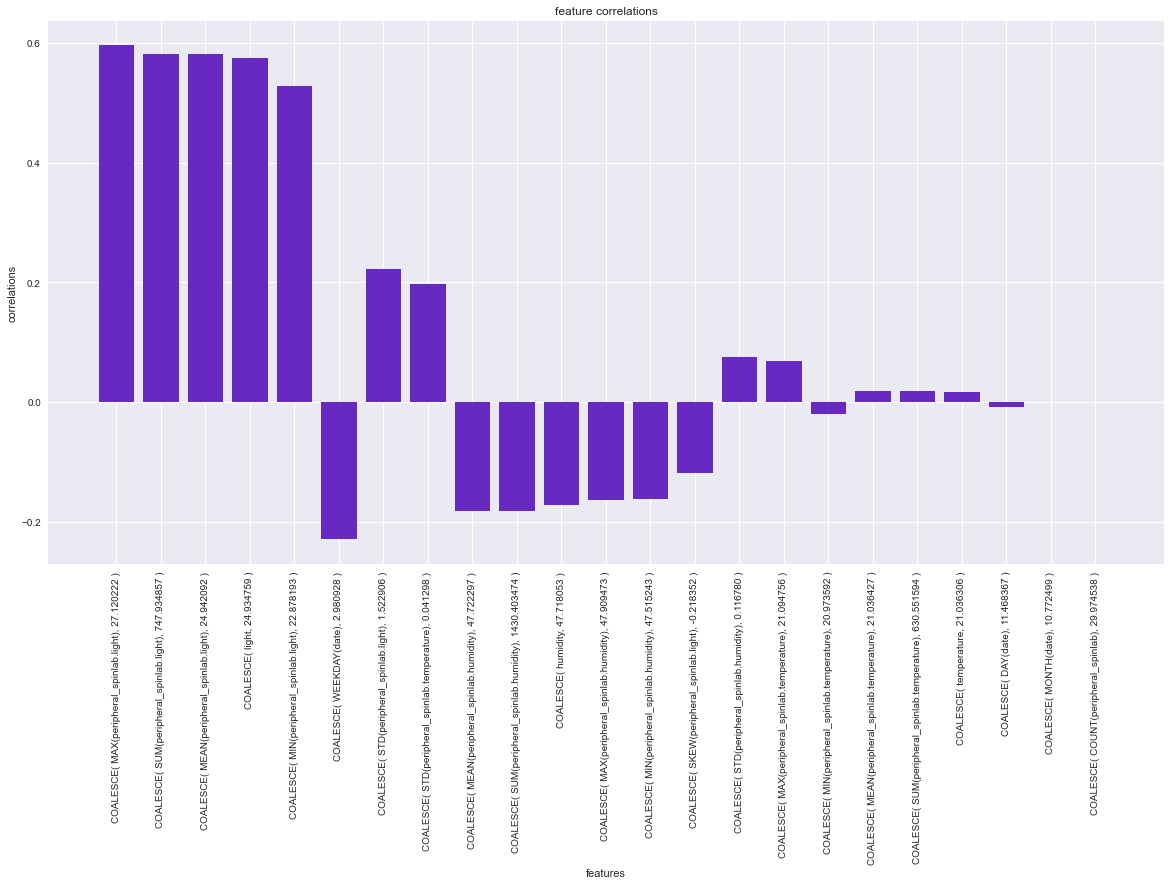

In [141]:
names, correlations = pipe_featuretools.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')
plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

In [518]:
pipe_featuretools

Pipeline(preprocessors=['Imputation'], feature_learners=[], 
         feature_selectors=['LogisticRegression'], include_categorical=False, 
         peripheral=[], population='POPULATION', 
         predictors=['LogisticRegression'], tags=['featuretools'], 
         share_selected_features=0.9230769230769231)

url: http://localhost:1709/getpipeline/aiKS8U/0/

In [142]:
fpr_ft, tpr_ft = pipe_featuretools.metrics.roc_curve()
fpr_g, tpr_g = pipe.metrics.roc_curve()

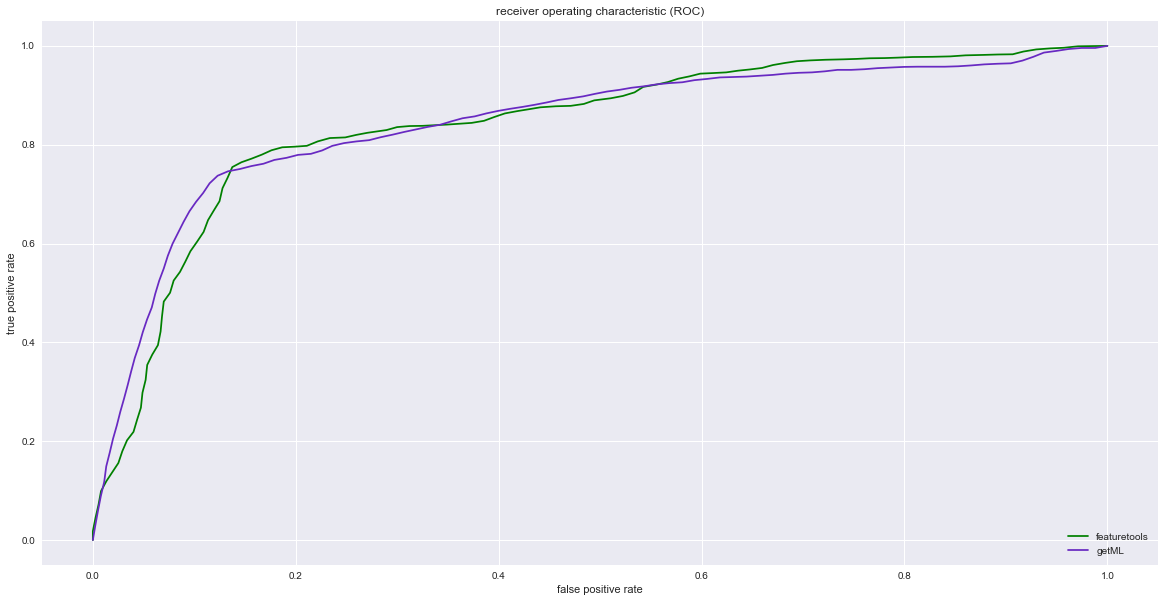

In [143]:
plt.subplots(figsize=(20, 10))

plt.plot(fpr_ft, tpr_ft, color='green', label='featuretools')
plt.plot(fpr_g, tpr_g, color='#6829c2', label='getML')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.legend(loc="lower right")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()